<a href="https://colab.research.google.com/github/shashavali-d/Challenges/blob/master/6SenseWorkItem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Purchase Prediction using Keras API**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer
from keras.layers.recurrent import LSTM

from sklearn.model_selection import GridSearchCV

import xgboost as xgb

Using TensorFlow backend.


In [0]:
#do not show warnings
import warnings 
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!unzip /content/drive/My\ Drive/6takehome.zip 

Archive:  /content/drive/My Drive/6takehome.zip
   creating: takehome/
  inflating: takehome/readme.txt     
  inflating: takehome/test.tsv       
  inflating: takehome/training.tsv   


In [0]:
#Read the train/test dataset in to Pandas datframe and assuming dataset path as current working directory

train_columns = ['user_id', 'activity_date', 'activity_type']

dftrain = pd.read_csv('./takehome/training.tsv', names = train_columns, sep = '\t')

dftest = pd.read_csv('./takehome/test.tsv', names = train_columns, sep = '\t')

 **Remove unnecessary columns 'CustomerSupport' and reduce the imbalanced data 'EmailOpen'**

>

In [0]:
df_sample = dftrain.loc[dftrain['activity_type'] == 'EmailOpen']
df = dftrain.loc[dftrain['activity_type'] != 'EmailOpen']
df = df.loc[df['activity_type'] != 'CustomerSupport']
df_sampled = df_sample.sample(frac=0.11)
df_train = pd.concat([df_sampled, df]).reset_index(drop = True)

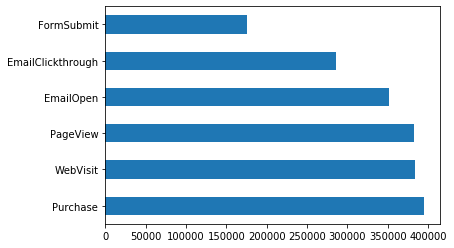

In [7]:
df_train['activity_type'].value_counts().plot(kind='barh')

In [0]:
activity_type_map = {
   'EmailOpen': 1,
   'EmailClickthrough': 2,
   'WebVisit': 3, 
   'PageView': 4, 
   'FormSubmit' : 5,
   'Purchase': 6  
}

In [0]:
df['activity_seq'] = df['activity_type'].apply(lambda x: activity_type_map[x])

In [10]:
#df_group = df.groupby(['user_id', 'activity_date', 'activity_type']).sum().reset_index()
#df = df.drop(['activity_date', 'activity_type'], axis = 1)
df.head(5)

,user_id,activity_date,activity_type,activity_seq
1,00002acbe042d69,2013-07-11,FormSubmit,5
30,0000ecf58c94668,2013-10-30,Purchase,6
31,0000ecf58c94668,2013-11-08,Purchase,6
32,0000ecf58c94668,2013-12-06,Purchase,6
33,0000ecf58c94668,2014-02-24,EmailClickthrough,2


In [11]:
grouped_df = df.groupby(['user_id'])
user_act_list = []
for i, j in grouped_df:
  temp_list = grouped_df.get_group(i)['activity_seq'].values
  temp_dict = {}
  temp_dict['user_id'] = i
  temp_dict['len'] = len(temp_list)
  temp_dict['activity_sequence'] = temp_list
  temp_dict['label'] = 1 if 6 in temp_list else 0
  user_act_list.append(temp_dict)

train_df = pd.DataFrame(user_act_list)
len(train_df)

191149

In [12]:
dftest['activity_seq'] = dftest['activity_type'].apply(lambda x: activity_type_map[x])
grouped_testdf = dftest.groupby(['user_id'])
testuser_act_list = []
for i, j in grouped_testdf:
  temp_list = grouped_testdf.get_group(i)['activity_seq'].values
  temp_dict = {}
  temp_dict['user_id'] = i
  temp_dict['len'] = len(temp_list)
  temp_dict['activity_sequence'] = temp_list
  testuser_act_list.append(temp_dict)

test_df = pd.DataFrame(testuser_act_list)
len(test_df)

132810

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191149 entries, 0 to 191148
Data columns (total 4 columns):
user_id              191149 non-null object
len                  191149 non-null int64
activity_sequence    191149 non-null object
label                191149 non-null int64
dtypes: int64(2), object(2)
memory usage: 5.8+ MB


In [14]:
train_df.drop(train_df[train_df['len'] > 300].index, inplace = True)
max_len = train_df.len.max()
max_len

300

In [15]:
train_df.tail(4)

,user_id,len,activity_sequence,label
191145,fffee47abaa249c,1,[2],0
191146,ffff8ce644e8032,1,[5],0
191147,ffffa46241fb077,2,"[6, 6]",1
191148,ffffa7beb541707,1,[5],0


In [0]:
labels = train_df.pop('label')

In [17]:
labels.value_counts()

1    103520
0     87063
Name: label, dtype: int64

In [24]:
X = train_df['activity_sequence']
X_TrainSeqs = sequence.pad_sequences(X, maxlen=max_len, padding='pre')
X_TrainSeqs = X_TrainSeqs.reshape(190583, 300, 1)
X_TrainSeqs.shape

(190583, 300, 1)

In [19]:
X_test = test_df['activity_sequence']
X_TestSeqs = sequence.pad_sequences(X_test, maxlen=max_len, padding='pre')
X_TestSeqs = X_TestSeqs.reshape(132810, 300, 6)
print (X_TestSeqs.shape)

(132810, 300, 1)


In [20]:
model = Sequential([
    InputLayer(input_shape=(300,1)),
    LSTM(64, return_sequences=False), 
    Dense(32, activation=tf.nn.relu),
    Dense(6, activation=tf.nn.softmax)
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 19,174
Trainable params: 19,174
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_TrainSeqs, labels, batch_size=256, epochs=5)

ValueError: ignored

In [0]:
predictions = model.predict(x=X_TestSeqs)

In [0]:
type(predictions)

numpy.ndarray

In [0]:
model.save('./pur_pred_5_epochs.h5')
predictions[100]

array([2.0563602e-06], dtype=float32)

In [0]:
pred_df = pd.DataFrame(predictions, columns=['probs'])
pred_df.head(5)

,probs
0,0.000002
1,0.000002
2,0.000002
3,0.000002
4,0.000002


In [0]:
indices = pred_df[pred_df['probs'].values > 0.5].index.tolist()

In [0]:
len(indices)

5

In [0]:
test_df['user_id'].iloc[indices].to_csv('./top_users.csv', index=False)

**XGBoost** model from sklearn

In [0]:
X_TrainSeqs = X_TrainSeqs.reshape(190583, 300)

data_dmatrix = xgb.DMatrix(data=X_TrainSeqs,label=labels)

In [0]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bynode= 1, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [0]:
xg_clf.fit(X_TrainSeqs, labels)
X_TestSeqs = X_TestSeqs.reshape(132810, 300)


In [0]:
preds = xg_clf.predict(X_TestSeqs)
len(preds)

132810

Parameter test using GridSearchCV

In [0]:
param_test = {
    'max_depth' : range(1, 4, 6),
    'min_child_weight' : range(1, 2, 3)
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier(),
                       param_grid = param_test, scoring = 'accuracy',
                       n_jobs = -1, iid = False, cv = 2)
gsearch.fit(X_TrainSeqs, labels)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 1, 'min_child_weight': 1}, 0.9602220738999433)